
XGBoost



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
from xgboost import XGBClassifier

Читаем данные 

In [ ]:
df = pd.read_csv('file.csv', sep = ';', index_col='ID')
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


Проверим, сбалансирована ли выборка (по результатам - можно считать сбалансированной)

In [ ]:
df['default_payment_next_month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default_payment_next_month, dtype: float64

Разделяем предикторы и отклик

In [ ]:
X = df.iloc[:, :-1].values  #
y = df.iloc[:, 23].values  # default_payment_next_month
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.3,random_state=17)

Подбираем параметры при помощи GridSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grid_param = {  
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 6]
}

model = XGBClassifier(random_state=17)
xgb_res = GridSearchCV(error_score='raise',
                        estimator=model, param_grid=grid_param, cv=5, 
                               pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

xgb_res.fit(X_train, y_train)

xgb_res.best_params_, xgb_res.best_score_

({'max_depth': 4, 'n_estimators': 100}, 0.8204761904761904)

In [ ]:
#Тренируем модель на полученных параметрах
xgb_res.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=17, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, 6],
                         'n_estimators': [100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [ ]:
# Строим предсказание модели
y_pred_train = xgb_res.predict(X_train)
y_pred_test = xgb_res.predict(X_holdout)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy on train set is ", accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", accuracy_score(y_holdout, y_pred_test)*100)

Accuracy on train set is  82.9952380952381
Accuracy on test set is  82.37777777777778


Один из способов понять, нужна ли калибровка 

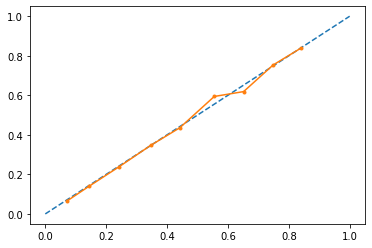

In [ ]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
probs = xgb_res.predict_proba(X_holdout)[:,1]
fop, mpv = calibration_curve(y_holdout, probs, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

По результатам - калибровка не нужна 

In [ ]:
# Еще раз посмотрим полученную точность
accuracy_score(y_holdout, xgb_res.predict(X_holdout))

0.8237777777777778